In [72]:
import pandas as pd
import numpy as np

######## READING IN THE DATA ########

# The needed files are as follows 
blast_output = "./filtered_fasta_blastout.txx"
metadata_plsdb = "./plsdb.tsv"
clusterfile = "./vae_clusters_within_radius_with_looners_complete_unsplit_candidate_plasmids.tsv" 

# On ESRUM they are located as follows:
# blast_output = "/maps/projects/rasmussen/scratch/ptracker/plasmid_graph/filtered_fasta_blastout.txx"
# metadata_plsdb = "/maps/projects/rasmussen/scratch/ptracker/plasmid_graph/data/PLSDB/plsdb.tsv"
# clusterfile = "/maps/projects/rasmussen/scratch/ptracker/plasmid_graph/data/vae_clusters_within_radius_with_looners_complete_unsplit_candidate_plasmids.tsv" 

# Read in the blast output 
df = pd.read_table(blast_output, sep="\t", header=None)
# link to output format: https://www.metagenomics.wiki/tools/blast/blastn-output-format-6
headers = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
df.columns = headers

# Getting metadata from PLSDB
metadata = pd.read_table(metadata_plsdb, low_memory=False)
df_metadata = df.merge(metadata, left_on="sseqid", right_on= "NUCCORE_ACC")

df_metadata["procent_coverage"] = df_metadata.length / df_metadata.Length
# apply Filter
df_filtered = df_metadata.query("pident > 90 and procent_coverage > 0.3")

# Read in the plasmid clusters
cluster_df = pd.read_table(clusterfile, sep="\t")                                             
df_metadata_cluster = df_filtered.merge(cluster_df, left_on="qseqid", right_on= "contigname")

# Make it so each cluster is only one node
df_metadata_cluster["realname"] = df_metadata_cluster.qseqid
df_metadata_cluster["qseqid"] = df_metadata_cluster.groupby("clustername")[["qseqid"]].transform("first")
df_filtered = df_metadata_cluster

In [73]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

######## PLOTTING THE NETWORK ########
# Adding the nodes which are from PLSDB
# and format for networkx, which is the following:
# (4, {"color": "red"}), (5, {"color": "green"})
dic_for_graph = []
for key, value_dic in df_filtered[["sseqid", "TAXONOMY_phylum"]].to_dict("index").items():
    value_dic["color"] = value_dic["TAXONOMY_phylum"]
    value_dic["alpha"] = 1
    value_dic["size"] = 2
    dic_for_graph.append((value_dic["sseqid"],  value_dic))
    
# Adding the nodes to the graph
import networkx as nx
G = nx.Graph()
G.add_nodes_from(dic_for_graph)

## Adding the nodes from our data and adding a color specific to them
toadd = {"color":"black", "alpha":0.8, "size": 8} 
nodes = [(x, toadd) for x in set(df_filtered["qseqid"])] 
G.add_nodes_from(nodes)

# Now adding the edges
edge_list = []
edge_color_list = []
for key, value_dic in df_filtered[["qseqid", "sseqid", "TAXONOMY_phylum"]].to_dict("index").items():
    G.add_edge(value_dic["qseqid"], value_dic["sseqid"], color=value_dic["TAXONOMY_phylum"])

def get_att(G, key):
    GD = dict(G.nodes(data=True))
    out = [GD[x][key] for x in GD.keys()]
    del GD
    return out

# TODO pehaps choose different colors for nodes etc.
color_dic = {
    "Bacteroidota": "#1f77b4",  # Blue
    "Pseudomonadota": "#aec7e8",  # Light blue
    "Bacillota": "#ff7f0e",  # Orange
    "Actinomycetota": "#ffbb78",  # Peach
    "Campylobacterota": "#2ca02c",  # Green
    "Deinococcota": "#98df8a",  # Light green
    "Nitrospirota": "#d62728",  # Red
    "Planctomycetota": "#ff9896",  # Light coral
    "Fusobacteriota": "#9467bd",  # Purple
    "Rhodothermota": "#c5b0d5",  # Lavender
    "Acidobacteriota": "#8c564b",  # Brown
    "Thermodesulfobacteriota": "#c49c94",  # Light brown
    "Verrucomicrobiota": "#e377c2",  # Pink
    'Cyanobacteriota':"#48996f",
    "black": "black",
    'Chloroflexota':"#994896",
    'Mycoplasmatota':"#91696f",
    'Chlorobiota':"#69916c",
    np.nan: "grey",
    '': "grey"
 }

# Layout for network
pos = nx.spring_layout(G, k=2*1/(np.sqrt(len(G.nodes)))) #TODO This one

# Create a label plot
fig, ax = plt.subplots()
fig.set_dpi(1000)
fig.set_size_inches(15,15)
# Create dummy plot elements for the legend
for label, color in color_dic.items():
    ax.plot([], [], color=color, label=label)

# Add a legend to the plot
ax.legend(title="Phyla Colors", loc="center left", bbox_to_anchor=(1, 0.5))

def get_att_edge(G, key):
    GD = list(G.edges(data=True))
    out = [x[2][key] for x in GD]
    del GD
    return out

# draw the plot
colors = [color_dic[x] for x in get_att(G, "color")] 
sizes = [x for x in get_att(G, "size")] 
edge_color_list_translated = [color_dic[x] for x in get_att_edge(G, "color")]
nx.draw_networkx_nodes(G, pos, node_color=colors , node_size=sizes, alpha=get_att(G, "alpha"))
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color=edge_color_list_translated)

0.017651821862348177

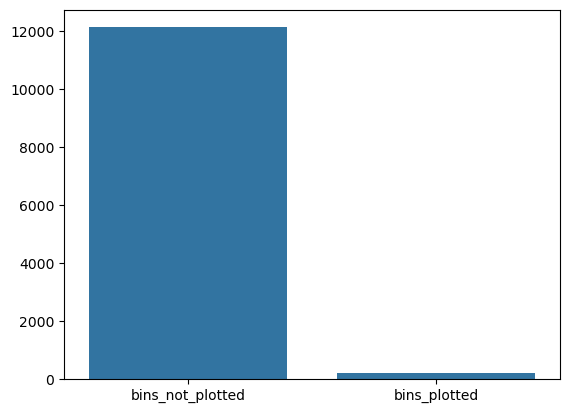

In [63]:
import seaborn as sns
## Plotting the number of bins not mapping to something.. Given the thresholds
bins_plotted = len(set(df_filtered.qseqid))
bins_all = len(set(cluster_df.contigname))
bins_not_plotted = bins_all - bins_plotted
bins_not_plotted 
bins_plotted
cluster_df
sns.barplot(y=[bins_not_plotted, bins_plotted], x=["bins_not_plotted", "bins_plotted"])
# And calculating the percent
bins_plotted/bins_all